# In this notebook, we are going to implement MLP model to analysis the data
# Applied oversampling for the imbalance data.
## https://en.wikipedia.org/wiki/Convolutional_neural_network


In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [8]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [9]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
5916  HAM_0004541  ISIC_0028838   nv  follow_up  65.0    male   
3689  HAM_0005065  ISIC_0031256   nv  follow_up  30.0    male   
5343  HAM_0006758  ISIC_0029234   nv  follow_up  35.0    male   
1797  HAM_0005992  ISIC_0032723  mel      histo  25.0  female   
1046  HAM_0001402  ISIC_0031558  bkl  consensus  50.0  female   

         localization  label  
5916            trunk      5  
3689  lower extremity      5  
5343  lower extremity      5  
1797             back      4  
1046  upper extremity      2  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [10]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

In [11]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [12]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

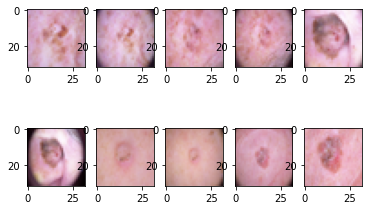

In [13]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [25]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
data = data.reshape(-1,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=87,stratify=label_to_one_hot)

In [26]:
# apply oversampling instead of class weight
from imblearn.over_sampling import SMOTE
smote_sample = SMOTE(random_state=87)
train_data_oversample, train_label_oversample = smote_sample.fit_resample(train_data, train_label)

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [29]:
#setup MLP model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Dense
num_classes = 7
dimension = image_size*image_size*3

model = Sequential()

#input Dense layer of 64x64x3 image input:
#with normal distribution + relu activation
model.add(Dense(units=1024,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))

#hidden layer 2
model.add(Dense(units=512,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.3))

#hidden layer 3
model.add(Dense(units=256,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.3))

#hidden layer 4
model.add(Dense(units=128,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.3))

#output Dense layer with 7 classes + softmax activation
model.add(Dense(units=num_classes,kernel_initializer='normal',activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

In [30]:
# Train

batch_size = 512
epochs = 100

train_history = model.fit(
    x=train_data_oversample,y=train_label_oversample,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2, shuffle=True)

Epoch 1/100
59/59 - 2s - loss: 1.7845 - acc: 0.2315 - val_loss: 4.0146 - val_acc: 0.0000e+00
Epoch 2/100
59/59 - 2s - loss: 1.5928 - acc: 0.3193 - val_loss: 4.0915 - val_acc: 0.0810
Epoch 3/100
59/59 - 2s - loss: 1.5172 - acc: 0.3541 - val_loss: 4.3949 - val_acc: 0.1157
Epoch 4/100
59/59 - 2s - loss: 1.4869 - acc: 0.3780 - val_loss: 4.5867 - val_acc: 0.1314
Epoch 5/100
59/59 - 2s - loss: 1.4449 - acc: 0.3968 - val_loss: 4.2253 - val_acc: 0.1226
Epoch 6/100
59/59 - 2s - loss: 1.4140 - acc: 0.4140 - val_loss: 4.5210 - val_acc: 0.1369
Epoch 7/100
59/59 - 2s - loss: 1.3779 - acc: 0.4342 - val_loss: 4.0859 - val_acc: 0.1398
Epoch 8/100
59/59 - 2s - loss: 1.3422 - acc: 0.4654 - val_loss: 3.6713 - val_acc: 0.1625
Epoch 9/100
59/59 - 2s - loss: 1.3528 - acc: 0.4603 - val_loss: 4.2556 - val_acc: 0.1551
Epoch 10/100
59/59 - 2s - loss: 1.3194 - acc: 0.4794 - val_loss: 3.8952 - val_acc: 0.1537
Epoch 11/100
59/59 - 2s - loss: 1.3043 - acc: 0.4834 - val_loss: 3.8257 - val_acc: 0.1341
Epoch 12/100
59

In [31]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

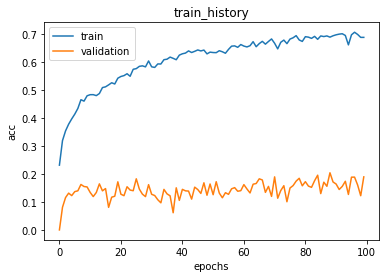

In [32]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

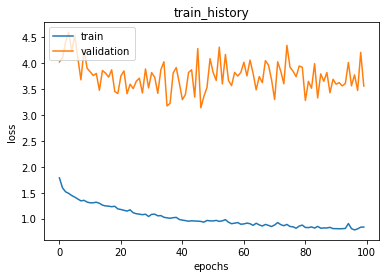

In [33]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [35]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

63/63 [==============================] - 1s 7ms/step - loss: 1.1993 - acc: 0.4978
Test accuracy: 0.497753381729126


In [37]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))
mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))

[4 4 4 ... 5 2 2]
predict   0   1    2   3    4    5  6
label                                
0        18  13   17   3   11    3  0
1        13  54   21   4   10    1  0
2        10  14  149   3   34   10  0
3         5   7    6   4    1    0  0
4         7   8   69   4  116   19  0
5        48  34  330  10  264  655  0
6         5   7    3   0    5    7  1
predicted  akiex  bcc  bkl  df  mel   nv  vasc
actual                                        
akiex         18   13   17   3   11    3     0
bcc           13   54   21   4   10    1     0
bkl           10   14  149   3   34   10     0
df             5    7    6   4    1    0     0
mel            7    8   69   4  116   19     0
nv            48   34  330  10  264  655     0
vasc           5    7    3   0    5    7     1
